In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from PIL import Image
import os
import cv2
from sklearn.metrics import accuracy_score
import shutil
import random

2024-02-19 21:14:52.715608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 21:14:53.617204: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 21:15:03.758658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/cudnn-8.4/8.4/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda11.2/toolkit/11.2.0/targets/x86_64-linux/lib:/cm/local/apps/gcc/7.2.0/lib:/cm/local/apps/gcc/7.2.0/lib64:/hom

In [2]:
ATTRIBUTE = "Sagittal"

In [3]:
train_df = pd.read_csv("crl_sag_augmented_train.csv")
val_df = pd.read_csv("crl_sag_augmented_test.csv")

In [4]:
train_df[ATTRIBUTE] = train_df[ATTRIBUTE].apply(str)
val_df[ATTRIBUTE] = val_df[ATTRIBUTE].apply(str)

In [6]:
# # Fixing the file names
# fname_append = '/content/drive/MyDrive/Fetal_experiments/TN_Neutral/TN_Neutral_dataset'
# train_file_names = train_df['filename']
# for i in range(len(train_file_names)):
#   train_file_names[i] = train_file_names[i].replace('\\', '/')
#   split_path = train_file_names[i].split('/')[1:]
#   joined_path = '/'.join(split_path)
#   joined_path = os.path.join(fname_append, joined_path)
#   train_file_names[i] = joined_path
# train_file_names

In [7]:
# fixing train_df
# train_df['filename'] = train_file_names
# file_names = train_df['filename']
# for i in range(len(file_names)):
#     file_names[i] = file_names[i].replace('\\', '/')
# train_df['filename'] = file_names
train_df

,Image ID,Sagittal,filename
0,image_129,1,CRL_Sagital/1/image_129.jpg
1,image_13,1,CRL_Sagital/1/image_13.jpg
2,image_85,0,CRL_Sagital/0/image_85.jpg
3,rotated_image_69,1,CRL_Sagital/1/rotated_image_69.jpg
4,rotated_image_120,0,CRL_Sagital/0/rotated_image_120.jpg
...,...,...,...
334,rotated_image_37,0,CRL_Sagital/0/rotated_image_37.jpg
335,image_108,1,CRL_Sagital/1/image_108.jpg
336,image_97,0,CRL_Sagital/0/image_97.jpg
337,rotated_image_160,0,CRL_Sagital/0/rotated_image_160.jpg


In [8]:
# # Fixing the val file names
# fname_append = '/content/drive/MyDrive/Fetal_experiments/TN_Neutral/TN_Neutral_dataset'
# val_file_names = val_df['filename']
# for i in range(len(val_file_names)):
#   val_file_names[i] = val_file_names[i].replace('\\', '/')
#   split_path = val_file_names[i].split('/')[1:]
#   joined_path = '/'.join(split_path)
#   joined_path = os.path.join(fname_append, joined_path)
#   val_file_names[i] = joined_path
# val_file_names

In [8]:
# fixing val_df
# val_df['filename'] = val_file_names
# file_names = val_df['filename']
# for i in range(len(file_names)):
#     file_names[i] = file_names[i].replace('\\', '/')
# val_df['filename'] = file_names
val_df

,Image ID,Sagittal,filename
0,image_155,1,CRL_Sagital/1/image_155.jpg
1,image_178,0,CRL_Sagital/0/image_178.jpg
2,image_10,0,CRL_Sagital/0/image_10.jpg
3,rotated_image_16,1,CRL_Sagital/1/rotated_image_16.jpg
4,image_68,0,CRL_Sagital/0/image_68.jpg
...,...,...,...
80,image_26,1,CRL_Sagital/1/image_26.jpg
81,rotated_image_7,1,CRL_Sagital/1/rotated_image_7.jpg
82,rotated_image_159,0,CRL_Sagital/0/rotated_image_159.jpg
83,rotated_image_40,1,CRL_Sagital/1/rotated_image_40.jpg


In [9]:
BATCH_SIZE = 8
IMG_SIZE = 224
NUM_CLASSES = train_df[ATTRIBUTE].nunique()
TRAIN_RATIO = 0.8

In [10]:
datagen = ImageDataGenerator (
    rescale = 1/255.,
)

training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = ATTRIBUTE,
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

val_generator = datagen.flow_from_dataframe (
    val_df,
    x_col = "filename",
    y_col = ATTRIBUTE,
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 339 validated image filenames belonging to 2 classes.
Found 85 validated image filenames belonging to 2 classes.


In [11]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(training_generator.classes),
    y = training_generator.classes)
class_weights = dict(zip(np.unique(training_generator.classes), class_weights))
class_weights

{0: 0.9576271186440678, 1: 1.0462962962962963}

In [12]:
classes = train_df[ATTRIBUTE].unique()

## GradCAM

In [13]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [14]:
@tf.function
def compute_gradcam_map(model, image, eps=1e-8):
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(get_last_layer_name(model)).output, model.output]
    )
    gradModel.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape(persistent = True) as tape:
        input_image = tf.cast(image, tf.float32)
        convOutputs, predictions = gradModel(input_image, training=False)
        classid = tf.argmax(predictions[0])
        loss = predictions[:, classid]

    grads = tape.gradient(loss, convOutputs)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    convOutputs = convOutputs[0]
    heatmap = convOutputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.image.resize(heatmap[tf.newaxis, ..., tf.newaxis], [IMG_SIZE, IMG_SIZE])
    heatmap = tf.squeeze(heatmap)

    heatmap = normalize(heatmap)
    return heatmap

In [15]:
@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []
#     return model.get_layer(index=47).name

In [16]:
@tf.function
def generate_gradcam(img, label, global_model):
    fused_heatmap = compute_gradcam_map(global_model, img)
    return fused_heatmap

In [17]:
@tf.function
def generate_gradcam_batch(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    return fused_heatmaps

In [18]:
def overlay_heatmap(image, heatmap, alpha=0.7,colormap=cv2.COLORMAP_JET):
    heatmap = cv2.cvtColor(cv2.applyColorMap((heatmap * 255.).astype("uint8"), colormap), cv2.COLOR_BGR2RGB)
    output = cv2.addWeighted((image * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    return output

## Densenet global branch

In [19]:
from tensorflow.keras.applications.densenet import DenseNet121

In [20]:
def build_base_model():

    backbone_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    flat = tf.keras.layers.Flatten()(backbone_model.output)
    dense = tf.keras.layers.Dense(256, activation='relu')(flat)
    classifier = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense)

    model = tf.keras.models.Model(inputs = backbone_model.input, outputs = classifier)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics = ['accuracy'])

    return model

In [21]:
global_model = build_base_model()

2024-02-19 21:16:52.611307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 21:16:54.089995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14625 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [22]:
for (i, l) in enumerate(global_model.layers):
    if i <= 426:
        l.trainable = False
    print(i, l.name, l.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [23]:
# from scratch
EPOCHS = 50

In [24]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('crl_sag_densenet/{epoch:02d}_{val_loss:.3f}_{val_accuracy:.3f}.h5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]

In [25]:
history = global_model.fit_generator(
    training_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = mycallbacks,
    class_weight=class_weights,
)

/tmp/ipykernel_360701/4118613365.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = global_model.fit_generator(
/home/ok_sikha/anaconda3/envs/tf_gpu_segnet/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50


2024-02-19 21:17:37.984343: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


43/43 [==============================] - ETA: 0s - loss: 0.8988 - accuracy: 0.7021
Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to crl_sag_densenet/01_0.556_0.706.h5
43/43 [==============================] - 34s 651ms/step - loss: 0.8988 - accuracy: 0.7021 - val_loss: 0.5561 - val_accuracy: 0.7059 - lr: 1.0000e-04
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9853
Epoch 2: val_accuracy improved from 0.70588 to 0.77647, saving model to crl_sag_densenet/02_0.543_0.776.h5
43/43 [==============================] - 28s 649ms/step - loss: 0.0808 - accuracy: 0.9853 - val_loss: 0.5426 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9912
Epoch 3: val_accuracy did not improve from 0.77647
43/43 [==============================] - 27s 622ms/step - loss: 0.0269 - accuracy: 0.9912 - val_loss: 0.5742 - val_accuracy: 0.7647 - lr: 1.0000e-04
Epoch 4/50
43/43 [==

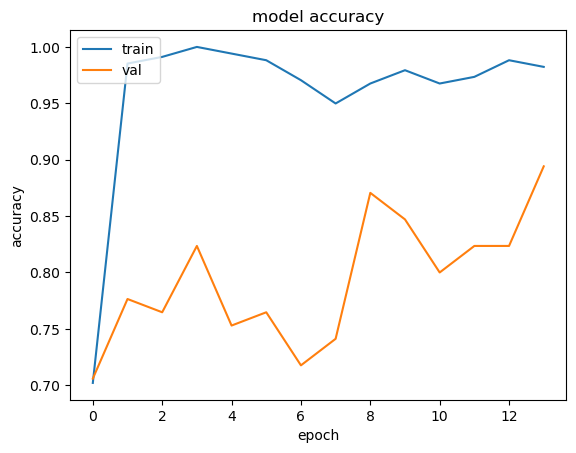

In [26]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

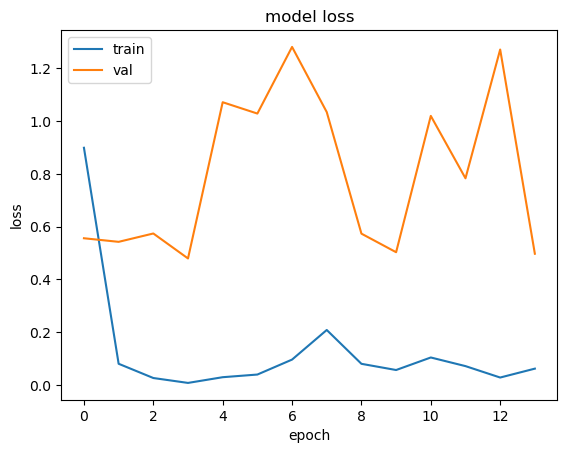

In [27]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
val_loss, val_accuracy = global_model.evaluate(val_generator)
print(val_loss, val_accuracy)

11/11 [==============================] - 3s 226ms/step - loss: 0.4975 - accuracy: 0.8941
0.4974907338619232 0.8941176533699036


## Make the gradcams

In [29]:
images, labels = training_generator.next()
print(len(images), len(labels))

8 8


In [30]:
heatmaps = generate_gradcam_batch(images, global_model, 0.6)

In [31]:
len(heatmaps)

8

In [32]:
training_generator.class_indices

{'0': 0, '1': 1}

In [33]:
print("True labels: ", tf.argmax(labels, axis = 1).numpy())
print("Predictions: ", tf.argmax(global_model(images), axis=1).numpy())

True labels:  [1 0 0 1 1 0 1 1]
Predictions:  [1 0 0 1 1 0 1 1]


In [34]:
overlaid = [overlay_heatmap(img, hmap.numpy()) for (img, hmap) in zip(images, heatmaps)]

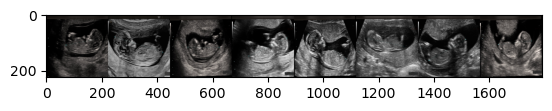

In [35]:
plt.imshow(np.hstack(images))

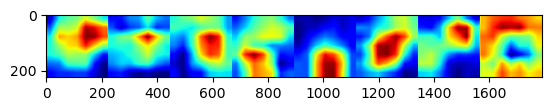

In [36]:
plt.imshow(np.hstack(heatmaps), cmap="jet")

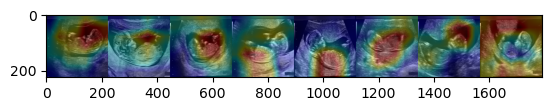

In [37]:
plt.imshow(np.hstack(overlaid))

In [38]:
len(training_generator)

43

In [40]:
# Loading all the images as arrays
pathzero = 'CRL_Sagital/0'
pathone = 'CRL_Sagital/1'
cla_zero_images = []
for i in os.listdir(pathzero):
    full_path = os.path.join(pathzero, i)
    img = Image.open(full_path)
    img = np.array(img.resize((224, 224)))
    cla_zero_images.append(img)
cla_zero_images = np.array(cla_zero_images)
cla_zero_images.shape

(222, 224, 224, 3)

In [41]:
cla_one_images = []
for i in os.listdir(pathone):
    full_path = os.path.join(pathone, i)
    img = Image.open(full_path)
    img = np.array(img.resize((224, 224)))
    cla_one_images.append(img)
cla_one_images = np.array(cla_one_images)
cla_one_images.shape

(202, 224, 224, 3)

In [44]:
cla_zero_preds = tf.argmax(global_model(cla_zero_images), axis=1).numpy()
cla_one_preds = tf.argmax(global_model(cla_one_images), axis=1).numpy()

In [45]:
# get the indices of the true positives and true negatives alone 
cla_zero_true = np.where(cla_zero_preds == 0)[0] 
cla_one_true = np.where(cla_one_preds == 1)[0]

In [46]:
imgs = np.concatenate((cla_one_images, cla_zero_images))
imgs.shape

(424, 224, 224, 3)

In [48]:
labels = [1]*cla_one_images.shape[0] + [0]*cla_zero_images.shape[0]
labels = np.array(labels)
labels.shape

(424,)

In [49]:
true_positives = []
for i in range(len(imgs)):
    img_exp = np.expand_dims(imgs[i], axis=0)
    _, accuracy = global_model.evaluate(img_exp, np.array([labels[i]]), verbose=0)
    if accuracy == 1.0 and labels[i] == 1:
        true_positives.append(i)

In [50]:
true_positives

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [51]:
global_model.evaluate(imgs, labels)

14/14 [==============================] - 3s 199ms/step - loss: 7.6885 - accuracy: 1.0000


[7.688465118408203, 1.0]

In [52]:
len(true_positives)

202

In [53]:
# Copy the images to a different folder 
cla_one_files = os.listdir(pathone)
path = 'CRL_Sagital_class_1_true'
for i in true_positives:
    src = os.path.join(pathone, cla_one_files[i])
    dest = os.path.join(path)
    shutil.copy(src, dest)

## Saving the gradcams for true positives

In [54]:
true_positive_cla_1_images = []
for i in true_positives:
    true_positive_cla_1_images.append(cla_one_images[i])
heatmaps_true_positives = generate_gradcam_batch(true_positive_cla_1_images, global_model, 0.6)

In [55]:
heatmaps_true_positives.shape

TensorShape([202, 224, 224])

In [56]:
overlaid_true_positives = [overlay_heatmap(img, hmap.numpy()) for (img, hmap) in zip(true_positive_cla_1_images, heatmaps_true_positives)]

(-0.5, 223.5, 223.5, -0.5)

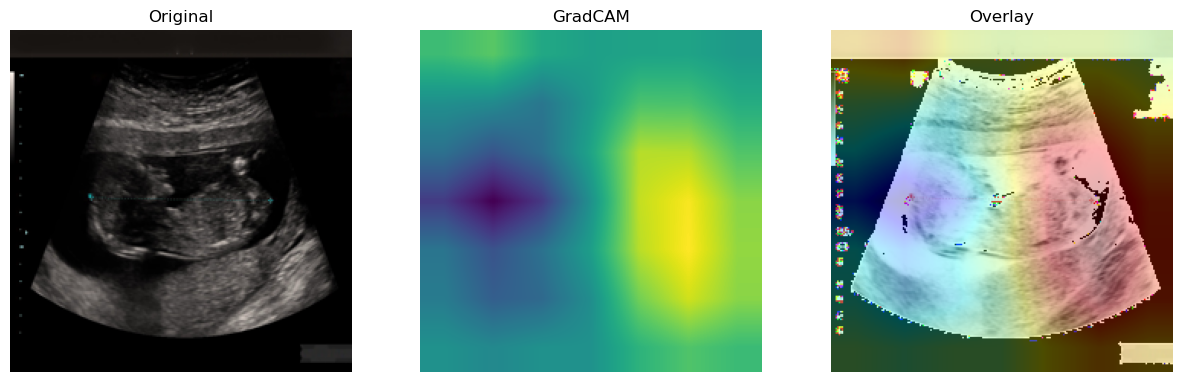

In [59]:
rnd_ind = random.randint(0, len(true_positives))
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(true_positive_cla_1_images[rnd_ind])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmaps_true_positives[rnd_ind])
plt.title('GradCAM')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlaid_true_positives[rnd_ind])
plt.title('Overlay')
plt.axis('off')

In [60]:
# Saving the images, gradcams and the overlays as numpy files
np.save("CRL_Sagital_c1tp_imgs", true_positive_cla_1_images)
np.save("CRL_Sagital_c1tp_gc", heatmaps_true_positives)
np.save("CRL_Sagital_c1tp_ogc", overlaid_true_positives)